In [35]:
import torch
import torchvision
import lightning as L
import os
import matplotlib.pyplot as plt

# Using Pytorch Lightning to Train CNN on MNIST Dataset

In [53]:
dataset = torchvision.datasets.MNIST(os.getcwd(), download=True, transform=torchvision.transforms.ToTensor())

Let's split the dataset into training, validation, and test splits.

In [54]:
generator = torch.Generator().manual_seed(42)
train, val, test = torch.utils.data.random_split(dataset=dataset, lengths=[0.8, 0.1, 0.1], generator=generator)

In [58]:
print(f'Length of training dataset: {len(train)}')
print(f' Length of validation dataset: {len(val)}')
print(f'Length of test dataset: {len(test)}')

Length of training dataset: 48000
 Length of validation dataset: 6000
Length of test dataset: 6000


In [56]:
train_loader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)
validation_loader = torch.utils.data.DataLoader(val, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=32, shuffle=True)

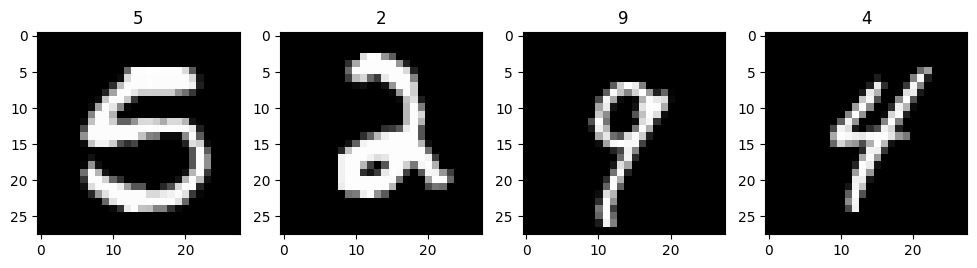

In [61]:
images, labels = next(iter(train_loader))
images.shape
fig, axes = plt.subplots(ncols=4, nrows=1, figsize=(12,7))
axes[0].imshow(images[0].squeeze(), cmap='gray')
axes[0].title.set_text(labels[0].item())
axes[1].imshow(images[-1].squeeze(), cmap='gray')
axes[1].title.set_text(labels[-1].item())
axes[2].imshow(images[15].squeeze(), cmap='gray')
axes[2].title.set_text(labels[15].item())
axes[3].imshow(images[6].squeeze(), cmap='gray')
axes[3].title.set_text(labels[6].item())

# Define the model

In [79]:
from typing import Any


class DigitClassifier(L.LightningModule):
    def __init__(self, num_channels, num_classes):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(num_channels, 32, kernel_size=3, padding=1)
        self.pool = torch.nn.MaxPool2d(2,2)
        self.conv2 = torch.nn.Conv2d(32, 54, kernel_size=3, padding=1)
        self.fc1 = torch.nn.Linear(54*7*7, 120)
        self.fc2 = torch.nn.Linear(120, 84)
        self.fc3 = torch.nn.Linear(84, num_classes)
        self.loss_function = torch.nn.CrossEntropyLoss()

    def forward(self, x):
        x = torch.nn.functional.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.nn.functional.relu(self.conv2(x))
        x = self.pool(x)
        #flatten tensor
        x = x.view(-1, 54*7*7)
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def training_step(self, batch, batch_idx):
        # x, y = batch
        # # flatten input tensor
        # x = x.view(x.size(0), -1)
        # scores = self.forward(x)
        # loss = self.loss_function(scores, y)
        loss, scores, y = self._common_step(batch, batch_idx)
        # self.log is a built-in function inherited from the LightningModule object.
        # It lets us keep track of certain metrics during training, etc.
        self.log('training_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        # # same as training step
        # x, y = batch
        # # flatten input tensor
        # x = x.view(x.size(0), -1)
        # scores = self.forward(x)
        # loss = self.loss_function(scores, y)
        loss, scores, y = self._common_step(batch, batch_idx)
        return loss

    def test_step(self, batch, batch_idx):
        # # same as training step
        # x, y = batch
        # # flatten input tensor
        # x = x.view(x.size(0), -1)
        # scores = self.forward(x)
        # loss = self.loss_function(scores, y)
        loss, scores, y = self._common_step(batch, batch_idx)
        self.log('test_loss', loss)
        return loss

    def _common_step(self, batch, batch_idx):
        # same as training, val, and test, but combined into one for simplicity
        x, y = batch
        # flatten input tensor
        #x = x.view(x.size(0), -1)
        scores = self.forward(x)
        loss = self.loss_function(scores, y)
        return loss, scores, y

    def predict_step(self, batch, batch_idx):
        x, y = batch
        x = x.view(x.size(0), -1)
        scores = self.forward(x)
        preds = torch.argmax(scores)
        return preds


    def configure_optimizers(self):
        # you could also include a scheduler here
        return torch.optim.Adam(self.parameters(), lr=0.001)

In [71]:
#images[0].view(28,28).size()

torch.Size([28, 28])

In [82]:
model = DigitClassifier(num_channels=1, num_classes=10)

In [84]:
if torch.backends.mps.is_available():
    print('MPS Detected')
else:
    print('No MPS detected')

MPS Detected


In [83]:
trainer = L.Trainer(accelerator='gpu', min_epochs=1, max_epochs=20)
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=validation_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | conv1         | Conv2d           | 320   
1 | pool          | MaxPool2d        | 0     
2 | conv2         | Conv2d           | 15.6 K
3 | fc1           | Linear           | 317 K 
4 | fc2           | Linear           | 10.2 K
5 | fc3           | Linear           | 850   
6 | loss_function | CrossEntropyLoss | 0     
---------------------------------------------------
344 K     Trainable params
0         Non-trainable params
344 K     Total params
1.378     Total estimated model params size (MB)


Epoch 7:  30%|███       | 455/1500 [00:04<00:10, 103.03it/s, v_num=2]      